# AAPL Trading Strategy based on Random Forest and Breakout System

In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px

## Data Pre-processing

In [504]:
AAPL = pd.read_excel("./data/AAPL_EQUITY.xlsx")
SPESG = pd.read_excel(('./data/SPESG_Index_5Y.xlsx')).dropna()

# Take SPESG and AAPL and combine them into one data frame: df['Date', 'SPESG', 'AAPL_Px', 'AAPL_Volume', 'AAPL_SMAVG(15)']
df = pd.merge(AAPL, SPESG, on='Date', how='inner')
new_columns = {'Last Px_x' : 'AAPL_Px', 'Volume': 'AAPL_Volume(M)', 'SMAVG(15)' : 'AAPL_SMAVG15(M)', 'Last Px_y': 'SPESG'}
df.rename(columns=new_columns, inplace=True)
df = df.dropna()
# Strip M and convert these columns from object into float64
df['AAPL_Volume(M)'] = df['AAPL_Volume(M)'].str.strip('M').astype('float64')
df['AAPL_SMAVG15(M)'] = df['AAPL_SMAVG15(M)'].str.strip('M').astype('float64')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.strftime('%A')
df

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day
0,2024-04-26,169.520,25.946,56.944,453.52,2024,2,4,Friday
1,2024-04-25,169.890,50.558,58.021,446.47,2024,2,4,Thursday
2,2024-04-24,169.020,48.252,58.231,447.28,2024,2,4,Wednesday
3,2024-04-23,166.900,49.538,58.193,446.95,2024,2,4,Tuesday
4,2024-04-22,165.840,48.116,58.179,441.80,2024,2,4,Monday
...,...,...,...,...,...,...,...,...,...
1255,2019-05-02,52.287,127.985,108.815,242.00,2019,2,5,Thursday
1256,2019-05-01,52.630,259.309,106.068,242.55,2019,2,5,Wednesday
1257,2019-04-30,50.167,186.140,98.319,244.34,2019,2,4,Tuesday
1258,2019-04-29,51.153,88.819,92.811,243.59,2019,2,4,Monday


## Calculate returns

In [505]:
ret_period = [1, 5, 10, 30, 60, 120, 250]
for p in ret_period:
    df[f'AAPL_Px_ret{p}'] = ((df['AAPL_Px'] - df['AAPL_Px'].shift(-p)) / df['AAPL_Px'].shift(-p)).round(4)

df['AAPL_ret_f1'] = df['AAPL_Px_ret1'].shift(-1)

# Calculate the 100-day moving average
df['AAPL_Px_100MA'] = df['AAPL_Px'].shift(-100).rolling(window=100).mean()
df['AAPL_Px_50MA'] = df['AAPL_Px'].shift(-50).rolling(window=50).mean()
df['AAPL_Px_10MA'] = df['AAPL_Px'].shift(-10).rolling(window=10).mean()

weekday_dummies = pd.get_dummies(df['Day']).astype(int)
df = pd.concat([df, weekday_dummies], axis=1)

In [506]:
df.head()

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day,AAPL_Px_ret1,...,AAPL_Px_ret250,AAPL_ret_f1,AAPL_Px_100MA,AAPL_Px_50MA,AAPL_Px_10MA,Friday,Monday,Thursday,Tuesday,Wednesday
0,2024-04-26,169.52,25.946,56.944,453.52,2024,2,4,Friday,-0.0022,...,-0.0009,0.0051,NaN,NaN,NaN,1,0,0,0,0
1,2024-04-25,169.89,50.558,58.021,446.47,2024,2,4,Thursday,0.0051,...,0.0088,0.0127,NaN,NaN,NaN,0,0,1,0,0
2,2024-04-24,169.02,48.252,58.231,447.28,2024,2,4,Wednesday,0.0127,...,0.0321,0.0064,NaN,NaN,NaN,0,0,0,0,1
3,2024-04-23,166.90,49.538,58.193,446.95,2024,2,4,Tuesday,0.0064,...,0.0191,0.0051,NaN,NaN,NaN,0,0,0,1,0
4,2024-04-22,165.84,48.116,58.179,441.80,2024,2,4,Monday,0.0051,...,0.0031,-0.0122,NaN,NaN,NaN,0,1,0,0,0


## Data splitting
Temoral Train/test split

In [507]:
df.sort_values(by='Date', ascending=True, inplace=True)

split_ts = pd.Timestamp("2021-04-06")
training_set = df[df['Date'] <= split_ts]
holdout_set = df[df['Date'] > split_ts]

## Return Analysis

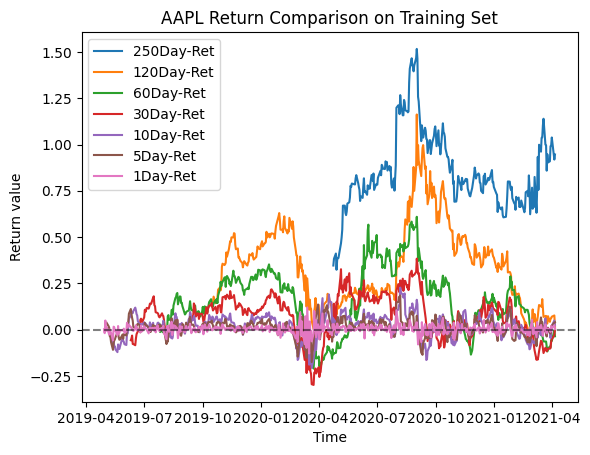

In [508]:
empty_row = training_set.isna().any(axis=1)
plt.plot(training_set['Date'], training_set['AAPL_Px_ret250'], label="250Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret120'], label="120Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret60'], label="60Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret30'], label="30Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret10'], label="10Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret5'], label="5Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret1'], label="1Day-Ret")

plt.axhline(y=0, color="black", alpha=0.5, linestyle='dashed')

plt.legend()
plt.title("AAPL Return Comparison on Training Set")
plt.xlabel("Time")
plt.ylabel("Return value")
plt.show()

**Conclusion** <br>
We can't choose linear regression or other interpolation method to fill the empty ret250 cells, since the 250-Day return seems fluctuating too much. <br>

**Basically, return with any peirod dropped significantly during 2020-4, and longer returns rises up around 2020-08, so the volatility is very large during 2020, which could easily makes the model over-fit.**

# Feature Engineering

In [509]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = training_set.dropna()
df['AAPL_Px_50MA_forward'] = df['AAPL_Px_50MA'].shift(-50)
df = df.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
# y = df['AAPL_ret_f1']
y = df['AAPL_Px_50MA_forward'].dropna()

# Define a list of feature combinations to try
feature_combinations = [
    ['AAPL_Px'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'],
    ['Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ['AAPL_Px_ret1'],
    # .... other combos
]

regressor = RandomForestRegressor()
# Train and evaluate the model for each feature combination
for i, features in enumerate(feature_combinations):
    X_subset = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.4, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    print(f"Feature Combination {i + 1}: {features} - R-squared: {r_squared}")

/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/477558658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AAPL_Px_50MA_forward'] = df['AAPL_Px_50MA'].shift(-50)


Feature Combination 1: ['AAPL_Px'] - R-squared: 0.9398886384077494
Feature Combination 2: ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'] - R-squared: 0.967138632517399
Feature Combination 3: ['Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] - R-squared: 0.9650728085533954
Feature Combination 4: ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] - R-squared: 0.9775852675332977
Feature Combination 5: ['AAPL_Px_ret1'] - R-squared: -0.45280312797592615


Since we didn't find any correlation between different features with forward one-day return, we will use "AAPL_Px_50MA_forward" as the prediction target.

# Modeling

### Random Forest

In [510]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


# We should re-read the df, since we fit the model in feature engineering section 
df = training_set.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Create Random Forest Regressor object
regressor = RandomForestRegressor()

cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')

# Evaluation & Measurement
## Model evaluation

In [511]:
print(cv_scores.round(3))
print(cv_scores.mean().round(3))

[-0.045  0.197  0.153  0.142  0.137]
0.117


### Testing on Holdout set

In [512]:
# holdout_set = holdout_set.dropna()
df = holdout_set.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']
cv_scores_holdout = cross_val_score(regressor, X, y, cv=10, scoring='r2')
print(cv_scores_holdout.round(3))
print(cv_scores_holdout.mean().round(3))

[0.008 0.111 0.089 0.191 0.086 0.194 0.149 0.136 0.215 0.258]
0.144


The model performed pretty good on the holdout set, with an average R-Squared value of 0.137

## Breakout System Building

In [513]:
df = training_set.dropna()
# df = df.dropna()
df

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day,AAPL_Px_ret1,...,AAPL_Px_ret250,AAPL_ret_f1,AAPL_Px_100MA,AAPL_Px_50MA,AAPL_Px_10MA,Friday,Monday,Thursday,Tuesday,Wednesday
1009,2020-04-23,68.757,124.814,160.931,237.96,2020,2,4,Thursday,-0.0039,...,0.3462,0.0288,71.49775,68.95486,69.2419,0,0,1,0,0
1008,2020-04-24,70.743,126.509,158.302,241.33,2020,2,4,Friday,0.0289,...,0.3830,-0.0039,71.51572,68.73196,69.4658,1,0,0,0,0
1007,2020-04-27,70.793,117.088,157.449,244.93,2020,2,4,Monday,0.0007,...,0.4111,0.0289,71.55502,68.51082,69.8404,0,1,0,0,0
1006,2020-04-28,69.645,112.005,151.462,243.43,2020,2,4,Tuesday,-0.0162,...,0.3233,0.0007,71.60255,68.30234,70.0884,0,0,0,1,0
1005,2020-04-29,71.933,137.281,147.088,250.08,2020,2,4,Wednesday,0.0329,...,0.3757,-0.0162,71.65037,68.07048,69.8767,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,2021-03-30,119.900,85.672,105.677,336.30,2021,1,3,Tuesday,-0.0123,...,0.9908,0.0015,126.15920,128.40430,122.0060,0,0,0,1,0
773,2021-03-31,122.150,118.324,106.103,337.46,2021,1,3,Wednesday,0.0188,...,0.9949,-0.0123,126.25380,128.25950,121.4390,0,0,0,0,1
772,2021-04-01,123.000,75.089,104.240,341.62,2021,2,4,Thursday,0.0070,...,1.0380,0.0188,126.32580,128.14590,121.1780,0,0,1,0,0
771,2021-04-05,125.900,88.651,104.277,346.78,2021,2,4,Monday,0.0236,...,0.9187,0.0070,126.36550,127.96530,121.4250,0,1,0,0,0


## Strategy performance measurement
### Sharpe Ratio

In [514]:
def sharpe_ratio_cal(df, period):
    if period == 30:
        risk_free_rate = 0.03 / 12
    else:
        risk_free_rate = (0.03 / 252) * period

    ret_mean = df[f'AAPL_Px_ret{period}'].mean()
    ret_std = df[f'AAPL_Px_ret{period}'].std()
    sharpe_ratio = ((ret_mean - risk_free_rate) / ret_std).round(3)
    print(sharpe_ratio)
    return sharpe_ratio

for p in ret_period:
    print(f"{p}-Day Return: Training & Holdout")
    sharpe_ratio_cal(training_set, p)
    sharpe_ratio_cal(holdout_set, p)

1-Day Return: Training & Holdout
0.084
0.024
5-Day Return: Training & Holdout
0.205
0.057
10-Day Return: Training & Holdout
0.294
0.083
30-Day Return: Training & Holdout
0.575
0.162
60-Day Return: Training & Holdout
0.871
0.212
120-Day Return: Training & Holdout
1.529
0.399
250-Day Return: Training & Holdout
3.86
0.78


|Sharpe Ratio | Ret1 | Ret5 | Ret10 | Ret30 | Ret120 | Ret250 |
| ------------|------|------|-------|--------|-------|--------|
|Training set |------|------|-------|-|-------|--------|
|Holdout set  |------|- |-------|-|-------|-|

### Maximum Dropdown

In [515]:
# Preassumably, the maximum dropdonw should happen in 2020

### Equity Graph

In [516]:
# # We will first test the 120-day return equity graph
# df = training_set
# initial_invest = 1

# df['EQ1'] = (1 + df['AAPL_Px_ret1'] ).cumprod() * initial_invest
# df['EQ5'] = (1 + df['AAPL_Px_ret5'] ).cumprod() * initial_invest
# df['EQ120'] = (1 + df['AAPL_Px_ret120'] ).cumprod() * initial_invest

# plt.plot(df['Date'], df['EQ1'], label="1Day")
# # plt.plot(df['Date'], df['EQ5'], label="5Day")
# # plt.plot(df['Date'], df['EQ120'], label="120Day")

# plt.legend()
# plt.title("Equity Graph")
# plt.xlabel("Time")
# plt.ylabel("Equity")
# plt.show()

In [517]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df is your DataFrame and it is already loaded
# df['EQ1'] = (1 + df['AAPL_Px_ret1']).cumprod() * initial_invest
# df['EQ5'] = (1 + df['AAPL_Px_ret5']).cumprod() * initial_invest
# df['EQ120'] = (1 + df['AAPL_Px_ret120']).cumprod() * initial_invest

# # Normalize the series to start at the same point
# df['EQ1_normalized'] = df['EQ1'] / df['EQ1'].iloc[0]
# df['EQ5_normalized'] = df['EQ5'] / df['EQ5'].iloc[0]
# df['EQ120_normalized'] = df['EQ120'] / df['EQ120'].iloc[0]

# plt.figure(figsize=(10, 6))
# # plt.plot(df['Date'], df['EQ1_normalized'], label="1-Day Returns")
# # plt.plot(df['Date'], df['EQ5_normalized'], label="5-Day Returns")
# plt.plot(df['Date'], df['EQ120_normalized'], label="120-Day Returns")

# plt.legend()
# plt.title("Normalized Equity Graph")
# plt.xlabel("Time")
# plt.ylabel("Normalized Equity")
# plt.grid(True)
# plt.show()

# Breakout System

In [518]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 1009 to 770
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             240 non-null    datetime64[ns]
 1   AAPL_Px          240 non-null    float64       
 2   AAPL_Volume(M)   240 non-null    float64       
 3   AAPL_SMAVG15(M)  240 non-null    float64       
 4   SPESG            240 non-null    float64       
 5   Year             240 non-null    int32         
 6   Quarter          240 non-null    int32         
 7   Month            240 non-null    int32         
 8   Day              240 non-null    object        
 9   AAPL_Px_ret1     240 non-null    float64       
 10  AAPL_Px_ret5     240 non-null    float64       
 11  AAPL_Px_ret10    240 non-null    float64       
 12  AAPL_Px_ret30    240 non-null    float64       
 13  AAPL_Px_ret60    240 non-null    float64       
 14  AAPL_Px_ret120   240 non-null    float64    

In [519]:
breakout_threshold = 1.1

df['Sell'] = df['AAPL_Px'] * (1 + df['AAPL_ret_f1']) > df['AAPL_Px_50MA'] * breakout_threshold
df['Buy'] = df['AAPL_Px'] * (1 + df['AAPL_ret_f1']) < df['AAPL_Px_50MA'] * breakout_threshold

print(df['Sell'].value_counts())
print(df['Buy'].value_counts())

Sell
False    147
True      93
Name: count, dtype: int64
Buy
True     147
False     93
Name: count, dtype: int64


/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/657898932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sell'] = df['AAPL_Px'] * (1 + df['AAPL_ret_f1']) > df['AAPL_Px_50MA'] * breakout_threshold
/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/657898932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy'] = df['AAPL_Px'] * (1 + df['AAPL_ret_f1']) < df['AAPL_Px_50MA'] * breakout_threshold


/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/268598720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ret_strategy'] = 0  # Initialize the column with zeros
/var/folders/n6/wdpx2fcx4ds7sr7yq7pd__lc0000gn/T/ipykernel_8989/268598720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EQ_test'] = (1 + df['ret_strategy']).cumprod() * 1


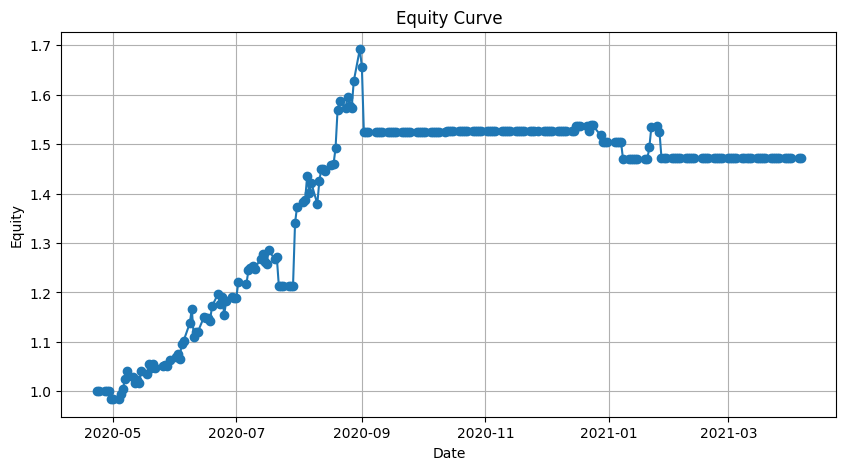

In [520]:
# Calculate returns based on trading signals

df['ret_strategy'] = 0  # Initialize the column with zeros 
df.loc[df['Sell'], 'ret_strategy'] = (df['AAPL_Px'].shift(-1) - df['AAPL_Px']) / df['AAPL_Px']
# df.loc[df['Buy'], 'ret_strategy'] = (df['AAPL_Px'] - df['AAPL_Px'].shift(-1)) / df['AAPL_Px']
df.loc[df['Buy'], 'ret_strategy'] = 0
# Calculate equity curve
df['EQ_test'] = (1 + df['ret_strategy']).cumprod() * 1

# Plotting the equity curve
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['EQ_test'], marker='o', linestyle='-')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.show()

In [525]:
df.to_excel("AAPL_training_result.xlsx")